<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Dental_Issue_classifiaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Description:

This dataset includes dental OPG X-rays collected from three different dental clinics. This dataset can be used for tasks like object detection, image analysis, disease classification, and segmentation. It has two folders: the object detection dataset folder and the classification dataset folder. The object detection folder contains 232 original and 604 augmented images and labels. The classification folder contains six distinct files for each class. The images are in JPG format, and the labels are in JSON format. The augmented data is split into training, validation, and testing sets in an 80:10:10 ratio.

Dataset collection:

• Source: Prescription Point Ltd, Lab Aid Specialized Hospital, Ibn Sina Diagnostic and Imaging Center. • Capture Method: Using android phone camera. • Anonymization: All data were rigorously anonymized to maintain confidentiality and privacy. • Informed Consent: All patients provided their consent in accordance with the dental ethical principles.

Dataset composition:

• Total Participants: 232 Male and female patients aged 10 years or older.

Variables:

• Healthy Teeth: 223
• Caries: 119
• Impacted Teeth: 87
• Broken Down Crown/ Root: 52
• Infection: 23
• Fractured Teeth: 13



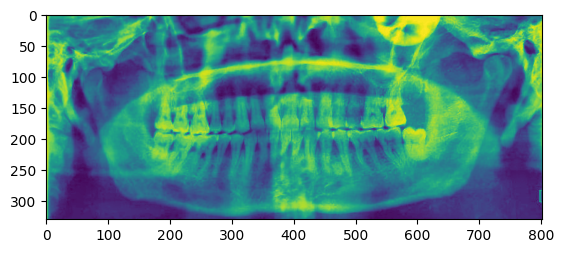

In [10]:
import os


dataset = '/content/drive/MyDrive/GenAI Course/Dental/Dental OPG (Classification)'

image_paths = []
labels = []

for classname in os.listdir(dataset):
    label = os.path.join(dataset, classname)
    for filename in os.listdir(label):
      image_path = os.path.join(label, filename)
      image_paths.append(image_path)
      labels.append(classname)

from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

train_paths[0]

# display image
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open(train_paths[0])
plt.imshow(image)
plt.show()

In [3]:
import torch
import torch as nn
import numpy as np

import torchvision
from torchvision import transforms, datasets

img = Image.open(train_paths[0]).convert("RGB")
img = np.array(img)


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

img = transform(img)
img

# create a function to transform test train adn validation datasets


def create_dataset(paths, labels, transform=None):
  dataset = []
  for path, label in zip(paths, labels):
    img = Image.open(path).convert("RGB")
    img = np.array(img)
    if transform is not None:
      img = transform(img)

    dataset.append([img, label])

  return dataset

train_dataset = create_dataset(train_paths, train_labels, transform)
test_dataset = create_dataset(test_paths, test_labels, transform)



In [39]:
#  create pre-trained resnet model
import torch
import torch.nn as nn


from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor

model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_classes = len(set(labels))

model.fc = nn.Linear(model.fc.in_features, num_classes)

# create resnet transfer learning and apply forward pass softmax function

class Resnet(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def forward(self, x):
    x = self.model(x)
    x = nn.functional.softmax(x, dim=1)
    return x

model = Resnet(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

from torch.utils.data import DataLoader, TensorDataset

# Create data loaders
train_labels_encoded = [list(set(labels)).index(label) for label in train_labels]
test_labels_encoded = [list(set(labels)).index(label) for label in test_labels]

train_data = TensorDataset(torch.stack([data[0] for data in train_dataset]), torch.tensor(train_labels_encoded))
test_data = TensorDataset(torch.stack([data[0] for data in test_dataset]), torch.tensor(test_labels_encoded))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 10  # Adjust the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Move data to device
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Evaluation (optional)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to device
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")





Train Epoch: 0 [0/413 (0%)]	Loss: 1.791170

Test set: Average loss: 0.0621, Accuracy: 49/104 (47%)

Train Epoch: 1 [0/413 (0%)]	Loss: 1.694880

Test set: Average loss: 0.0622, Accuracy: 49/104 (47%)

Train Epoch: 2 [0/413 (0%)]	Loss: 1.574532

Test set: Average loss: 0.0657, Accuracy: 36/104 (35%)

Train Epoch: 3 [0/413 (0%)]	Loss: 1.755325

Test set: Average loss: 0.0623, Accuracy: 49/104 (47%)

Train Epoch: 4 [0/413 (0%)]	Loss: 1.705950

Test set: Average loss: 0.0635, Accuracy: 44/104 (42%)

Train Epoch: 5 [0/413 (0%)]	Loss: 1.657394

Test set: Average loss: 0.0623, Accuracy: 49/104 (47%)

Train Epoch: 6 [0/413 (0%)]	Loss: 1.563808

Test set: Average loss: 0.0634, Accuracy: 47/104 (45%)

Train Epoch: 7 [0/413 (0%)]	Loss: 1.578190

Test set: Average loss: 0.0621, Accuracy: 49/104 (47%)

Train Epoch: 8 [0/413 (0%)]	Loss: 1.510909

Test set: Average loss: 0.0621, Accuracy: 49/104 (47%)

Train Epoch: 9 [0/413 (0%)]	Loss: 1.761868

Test set: Average loss: 0.0622, Accuracy: 49/104 (47%)



# apply transformers

In [22]:
# Apply transformation to dataset

#  create pre-trained resnet model
import torch
import torch.nn as nn

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

def create_dataset(paths, labels, transform=None):
  dataset = []
  for path, label in zip(paths, labels):
    img = Image.open(path)
    #img = np.array(img)
    if transform is not None:
      img = transform(img)

    dataset.append([img, label])

  return dataset

train_dataset = create_dataset(train_paths, train_labels, transform)
test_dataset = create_dataset(test_paths, test_labels, transform)

from torch.utils.data import DataLoader, TensorDataset

# Create data loaders
train_labels_encoded = [list(set(labels)).index(label) for label in train_labels]
test_labels_encoded = [list(set(labels)).index(label) for label in test_labels]

train_data = TensorDataset(torch.stack([data[0] for data in train_dataset]), torch.tensor(train_labels_encoded))
test_data = TensorDataset(torch.stack([data[0] for data in test_dataset]), torch.tensor(test_labels_encoded))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
#  create pre-trained resnet model
import torch
import torch.nn as nn

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor

model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_classes = len(set(labels))

model.fc = nn.Linear(model.fc.in_features, num_classes)

# create resnet transfer learning and apply forward pass softmax function

# class Resnet1(nn.Module):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model
#     self.dropout = nn.Dropout(0.5)

#   def forward(self, x):
#     x = self.model(x)
#     x = nn.functional.softmax(x, dim=1)
#     return x

model = Resnet1(model)

# change optimization function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()


# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 20  # Adjust the number of epochs as needed
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # Move data to device
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Evaluation (optional)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to device
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")





Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


Train Epoch: 0 [0/413 (0%)]	Loss: 1.791680

Test set: Average loss: 0.0687, Accuracy: 27/104 (26%)

Train Epoch: 1 [0/413 (0%)]	Loss: 1.782011

Test set: Average loss: 0.0683, Accuracy: 40/104 (38%)

Train Epoch: 2 [0/413 (0%)]	Loss: 1.780705

Test set: Average loss: 0.0674, Accuracy: 46/104 (44%)

Train Epoch: 3 [0/413 (0%)]	Loss: 1.737494

Test set: Average loss: 0.0661, Accuracy: 47/104 (45%)

Train Epoch: 4 [0/413 (0%)]	Loss: 1.703952

Test set: Average loss: 0.0654, Accuracy: 47/104 (45%)

Train Epoch: 5 [0/413 (0%)]	Loss: 1.705085

Test set: Average loss: 0.0642, Accuracy: 47/104 (45%)

Train Epoch: 6 [0/413 (0%)]	Loss: 1.622150

Test set: Average loss: 0.0635, Accuracy: 47/104 (45%)

Train Epoch: 7 [0/413 (0%)]	Loss: 1.718172

Test set: Average loss: 0.0631, Accuracy: 47/104 (45%)

Train Epoch: 8 [0/413 (0%)]	Loss: 1.653971

Test set: Average loss: 0.0625, Accuracy: 47/104 (45%)

Train Epoch: 9 [0/413 (0%)]	Loss: 1.611333

Test set: Average loss: 0.0623, Accuracy: 47/104 (45%)



In [15]:
import torchvision
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

dataset = '/content/drive/MyDrive/GenAI Course/Dental/Dental OPG (Classification)'

image_paths = []
labels = []

for classname in os.listdir(dataset):
    label = os.path.join(dataset, classname)
    for filename in os.listdir(label):
      image_path = os.path.join(label, filename)
      image_paths.append(image_path)
      labels.append(classname)


train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet mean/std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def create_dataset(paths, labels, transform=None):
  dataset = []
  for path, label in zip(paths, labels):
    img = Image.open(path).convert("RGB")
    #img = np.array(img)
    if transform is not None:
      img = transform(img)

    dataset.append([img, label])

  return dataset

train_dataset = create_dataset(train_paths, train_labels, data_transforms['train'])
test_dataset = create_dataset(test_paths, test_labels, data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}


In [24]:
#shape of train_dataset
# print dataloaer sample

for inputs, labels in dataloaders['train']:
  print(inputs.shape)
  print(len(labels))
  break

torch.Size([32, 3, 224, 224])
32


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# print(f"Classes: {class_names}")

# Define Model (Using ResNet18 Pretrained)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(labels))  # Adjust for 6 classes
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate decay

# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, correct_preds = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), torch.tensor([list(set(labels)).index(label) for label in labels]).to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_preds += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = correct_preds.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the Model
num_epochs = 25
train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs)

# Plot Training and Validation Curves
def plot_curves(train_values, val_values, metric):
    epochs = range(1, len(train_values) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_values, label=f"Train {metric}")
    plt.plot(epochs, val_values, label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Train vs Validation {metric}")
    plt.legend()
    plt.show()

plot_curves(train_loss, val_loss, "Loss")
plot_curves(train_acc, val_acc, "Accuracy")

# Check Overfitting/Underfitting
if train_acc[-1] > 0.8 and abs(train_acc[-1] - val_acc[-1]) < 0.1:
    print("Model is well-fitted!")
elif train_acc[-1] > val_acc[-1]:
    print("Model is overfitting. Try more regularization.")
else:
    print("Model is underfitting. Try a larger model or more training.")

# Save Model
torch.save(model.state_dict(), "dental_model.pth")
print("Model saved as dental_model.pth.")


Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
Train Loss: 2.3689 Acc: 0.2809
Val Loss: 2.5527 Acc: 0.2308
Epoch 2/25
----------
Train Loss: 2.0652 Acc: 0.3850
Val Loss: 2.9447 Acc: 0.2404
Epoch 3/25
----------
